# 共起情報の可視化

In [ ]:
import Pkg
Pkg.add("HTTP")
Pkg.add("ZipFile")
Pkg.add("StringEncodings")
Pkg.add("Awabi")
Pkg.add("GraphPlot")
Pkg.add("Graphs")
Pkg.add("Compose")
Pkg.add("Cairo")
Pkg.add("Fontconfig")

## １．テキストデータの取得

In [1]:
using HTTP
using ZipFile
using StringEncodings

# 夏目漱石の「こころ」のzipファイルのURL
url = "https://www.aozora.gr.jp/cards/000148/files/773_ruby_5968.zip"

# URLからデータを取得
dat = HTTP.get(url)

# zipファイルから圧縮前の元データを取得
r = ZipFile.Reader(IOBuffer(dat.body))

# 最初に見つかったテキストファイルを取得する
f = nothing
for file in r.files
    if findlast(".txt", file.name) != nothing
        f = file
        break
    end
end
close(r)

In [2]:
# ファイル名を確認する
f.name

"kokoro.txt"

In [3]:
# 文字コードShiftJISで記述されたテキストファイルを読み込む：CP932を指定する
list = readlines(f, enc"CP932");

## ２．テキストデータのクレンジング

In [4]:
# 先頭の注釈行判定用
note_line = r"^--------"
is_note = false
# 末尾の奥付判定用
endmark = r"^(底本|底本の親本|翻訳の底本|初出)："
# 最終結果の格納領域
new_lines = []

for line in list
    # 不要行を削除する（new_lineへの登録をskipすることで実現）
    ## 先頭の注釈行の削除
    if is_note
        if occursin(note_line, line)
            is_note = false
        end
        continue
    else
        if occursin(note_line, line)
            is_note = true
            continue
        end
    end
    ## 末尾の奥付を削除
    if occursin(endmark, line)
        break
    end
    # 不要行削除ここまで
    
    # ルビ、および、入力者注の削除
    line = replace(line, r"［＃[^］]+］" => "")
    line = replace(line, r"《[^》]+》" => "")
    
    # 形態素解析に長文を渡したり、不要な呼び出しをしないように、文字列を調整
    ## 句点「。」の後で分割する
    slines = split(replace(line, r"。" => "。\n"), "\n")
    for ll in slines
        ## 行頭の空白文字列を削除
        ll = replace(ll, r"^[　 ]+" => "")
        ## 空行は削除
        if length(ll) == 0
            continue
        end
        # 処理済み文字列を格納
        push!(new_lines, ll)
    end
end

In [5]:
new_lines

5172-element Vector{Any}:
 "こころ"
 "夏目漱石"
 "上　先生と私"
 "一"
 "私はその人を常に先生と呼んでいた。"
 "だからここでもただ先生と書くだけで本名は打ち明けない。"
 "これは世間を憚かる遠慮というよりも、その方が私にとって自然だからである。"
 "私はその人の記憶を呼び起すごとに、すぐ「先生」といいたくなる。"
 "筆を執っても心持は同じ事である。"
 "よそよそしい頭文字などはとても使う気にならない。"
 "私が先生と知り合いになったのは鎌倉である。"
 "その時私はまだ若々しい書生であった。"
 "暑中休暇を利用して海水浴に行った友達からぜひ来いという端書を受け取ったので、私は多少の金を工面して、出掛ける事にした。"
 ⋮
 "もう何にもする事はありません。"
 "この手紙があなたの手に落ちる頃には、私はもうこの世にはいないでしょう。"
 "とくに死んでいるでしょう。"
 "妻は十日ばかり前から市ヶ谷の叔母の所へ行きました。"
 "叔母が病気で手が足りないというから私が勧めてやったのです。"
 "私は妻の留守の間に、この長いものの大部分を書きました。"
 "時々妻が帰って来ると、私はすぐそれを隠しました。"
 "私は私の過去を善悪ともに他の参考に供するつもりです。"
 "しかし妻だけはたった一人の例外だと承知して下さい。"
 "私は妻には何にも知らせたくないのです。"
 "妻が己れの過去に対してもつ記憶を、なるべく純白に保存しておいて" ⋯ 150 bytes ⋯ "られた私の秘密として、すべてを腹の中にしまっておいて下さい。"
 "」"

## ３．形態素解析～数え上げ～共起強度の計算

### 3-1 形態素解析＆数え上げ

In [6]:
using Awabi

# 形態素解析器の設定
## Linux / Mac
#tokenizer = Tokenizer()
## Windows：
#dic = Dict("dicdir" => "C:\\Program Files (x86)\\MeCab\\dic\\ipadic")
#tokenizer = Tokenizer(dic)
## SageMaker Studio Lab
rcfile = "/home/studio-lab-user/mecab/etc/mecabrc"
tokenizer = Tokenizer(rcfile)

# 数え上げ格納領域
word_counts = Dict{String, Int}()
coll_counts = Dict{Tuple{String, String}, Int}()

# 形態素解析＆数え上げ
for line in new_lines
    # 1文を形態素解析
    tokens = tokenize(tokenizer, line)
    new_tokens = []
    for token in tokens
        attr = split(token[2], ",")
        hinsi = attr[1]
        hinsi2 = attr[2]
        surface = token[1] # 表記
        basic = (attr[7] != "*") ? attr[7] : surface   # 形態素の基本形
        # 一文字のひらがな・カタカナ・長音「ー」・波線「〜」を対象外にする
        if hinsi in ["名詞", "動詞", "形容詞"] && !(hinsi2 in ["接尾", "非自立"]) &&
            (length(surface) > 1 || ((surface < "ぁ" || surface > "ヶ") && !(surface in ["ー", "～"])))
            push!(new_tokens, basic)
        end
    end
    # 行中の形態素の重複を除去
    unique!(new_tokens)
    # 形態素数と共起数を数え上げ
    for (index, surface) in enumerate(new_tokens)
        word_counts[surface] = get(word_counts, surface, 0) + 1
        if index < length(new_tokens)
            for surface2 in new_tokens[index+1:end]
                if surface < surface2
                    pair = (surface, surface2)
                    coll_counts[pair] = get(coll_counts, pair, 0) + 1
                elseif surface > surface2
                    pair = (surface2, surface)
                    coll_counts[pair] = get(coll_counts, pair, 0) + 1
                end
            end
        end
    end
end

In [7]:
# 形態素出現数
word_counts

Dict{String, Int64} with 4852 entries:
  "騒ぐ" => 2
  "充ち… => 4
  "糸"   => 4
  "顧み… => 9
  "ため… => 2
  "あき… => 1
  "出す" => 67
  "近付… => 1
  "剣"   => 1
  "送金" => 1
  "なす… => 3
  "今頃" => 1
  "もっ… => 2
  "持物" => 1
  "重ん… => 1
  "細か… => 3
  "後生" => 1
  "附近" => 1
  "急ぐ" => 10
  "執る" => 7
  "攫む" => 5
  "味方" => 1
  "臆面" => 1
  "刺激" => 1
  "葬式" => 2
  ⋮      => ⋮

In [8]:
# 共起出現数
coll_counts

Dict{Tuple{String, String}, Int64} with 81807 entries:
  ("人間", "対")    => 2
  ("努力", "約束")  => 1
  ("よい", "出る")  => 1
  ("平均", "普通")  => 1
  ("山", "捕る")    => 1
  ("死ぬ", "生きな… => 1
  ("その後", "事")  => 1
  ("太織", "蒲団")  => 1
  ("ハンケチ", "手… => 1
  ("先生", "過去")  => 2
  ("柔らかい", "若… => 1
  ("大学", "通り")  => 1
  ("いう", "席")    => 1
  ("動揺", "好い")  => 1
  ("先生", "立ち上… => 1
  ("いう", "団扇")  => 1
  ("できる", "装う… => 1
  ("何", "度数")    => 1
  ("受け取る", "見… => 1
  ("投げかける", "… => 1
  ("堅い", "括る")  => 2
  ("嬉しい", "性質… => 1
  ("淋しい", "非常… => 1
  ("すべて", "未亡… => 1
  ("そこ", "書見")  => 1
  ⋮                 => ⋮

### 3-2 出現数データを調整

In [9]:
# 最小出現数：出現数が極端に小さいものを除外するため
mincount = 10

# 出現数一覧から指定に基づいて除外
word_counts = Dict((k, v) for (k, v) in collect(word_counts) if v >= mincount)
coll_counts = Dict(((w1, w2), v) for ((w1, w2) , v) in collect(coll_counts) if v >= mincount)

Dict{Tuple{String, String}, Int64} with 714 entries:
  ("私", "見え… => 38
  ("奥さん", "… => 10
  ("問い", "私… => 10
  ("私", "頼む… => 15
  ("座敷", "私… => 11
  ("父", "私")  => 128
  ("いう", "見… => 11
  ("ある", "考… => 15
  ("先生", "眼… => 10
  ("室", "彼")  => 12
  ("私", "答え… => 52
  ("私", "買う… => 13
  ("何", "先生… => 20
  ("ない", "必… => 15
  ("ある", "意… => 12
  ("世の中", "… => 16
  ("出す", "私… => 38
  ("私", "自白… => 13
  ("やる", "私… => 15
  ("私", "静か… => 12
  ("お嬢さん",… => 11
  ("私", "胸")  => 33
  ("女", "若い… => 10
  ("ない", "見… => 10
  ("人", "私")  => 69
  ⋮             => ⋮

In [10]:
word_counts

Dict{String, Int64} with 525 entries:
  "友達" => 27
  "大丈… => 16
  "忙し… => 12
  "働く" => 10
  "済む" => 20
  "先刻" => 16
  "目的" => 18
  "瞬間" => 10
  "見せ… => 43
  "出る" => 175
  "過去" => 32
  "裏"   => 14
  "彼"   => 275
  "安心" => 17
  "長い" => 32
  "持つ" => 48
  "苦痛" => 13
  "でき… => 142
  "学校" => 35
  "愛"   => 13
  "傍"   => 41
  "先"   => 42
  "なれ… => 17
  "家族" => 13
  "なく… => 15
  ⋮      => ⋮

In [11]:
coll_counts

Dict{Tuple{String, String}, Int64} with 714 entries:
  ("私", "見え… => 38
  ("奥さん", "… => 10
  ("問い", "私… => 10
  ("私", "頼む… => 15
  ("座敷", "私… => 11
  ("父", "私")  => 128
  ("いう", "見… => 11
  ("ある", "考… => 15
  ("先生", "眼… => 10
  ("室", "彼")  => 12
  ("私", "答え… => 52
  ("私", "買う… => 13
  ("何", "先生… => 20
  ("ない", "必… => 15
  ("ある", "意… => 12
  ("世の中", "… => 16
  ("出す", "私… => 38
  ("私", "自白… => 13
  ("やる", "私… => 15
  ("私", "静か… => 12
  ("お嬢さん",… => 11
  ("私", "胸")  => 33
  ("女", "若い… => 10
  ("ない", "見… => 10
  ("人", "私")  => 69
  ⋮             => ⋮

### 3-3 共起強度（Jaccard係数）の計算

In [12]:
#Jaccard係数の定義
function jaccard(coll_count, w1_count, w2_count)
    coll_count / (w1_count + w2_count - coll_count)
end

# エッジに対して共起強度を計算し、共起強度の大きい順に並べる
edge_val_list = [(w1, w2, jaccard(v, word_counts[w1], word_counts[w2])) for ((w1, w2), v) in collect(coll_counts)]
sort!(edge_val_list, rev = true, by =x -> x[3])

714-element Vector{Tuple{String, String, Float64}}:
 ("手紙", "書く", 0.19491525423728814)
 ("五", "十", 0.18253968253968253)
 ("付く", "落ちる", 0.17333333333333334)
 ("三", "十", 0.17142857142857143)
 ("母", "父", 0.16939890710382513)
 ("見る", "顔", 0.16556291390728478)
 ("十", "四", 0.14728682170542637)
 ("三", "二", 0.13214285714285715)
 ("二", "十", 0.10819672131147541)
 ("利く", "口", 0.10638297872340426)
 ("先生", "私", 0.1061555473645411)
 ("女", "若い", 0.10309278350515463)
 ("六", "十", 0.0975609756097561)
 ⋮
 ("私", "結婚", 0.004084967320261438)
 ("信用", "私", 0.004084967320261438)
 ("影", "私", 0.004084967320261438)
 ("固い", "私", 0.004084967320261438)
 ("元", "私", 0.004084967320261438)
 ("私", "足", 0.004083299305839118)
 ("床", "私", 0.004081632653061225)
 ("田舎", "私", 0.004079967360261118)
 ("下", "私", 0.0040766408479412965)
 ("生れる", "私", 0.004074979625101874)
 ("着く", "私", 0.004073319755600814)
 ("恋", "私", 0.0040683482506102524)

## ４．グラフ表示
### 共起強度の上位N件のエッジと、それにつながるノード

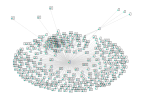

In [13]:
using GraphPlot
using Graphs

# 除外する形態素の一覧
ngwords = ["する", "やる", "できる", "ある", "なる", "それ"]

# 表示するエッジ数
disp_edges = 1000
if length(edge_val_list) < disp_edges
    disp_edges = length(edge_val_list)
end

# 表示する形態素・エッジを抽出
disp_word_list = Vector{String}()
disp_edge_list = []
for (w1, w2, v) in edge_val_list[1:disp_edges]
    if ! (w1 in ngwords || w2 in ngwords)
        push!(disp_edge_list, (w1, w2))
        push!(disp_word_list, w1)
        push!(disp_word_list, w2)
    end
end
unique!(disp_word_list)
word2num = Dict((word, num) for (num, word) in enumerate(disp_word_list))
edges = [(word2num[w1], word2num[w2]) for (w1, w2) in disp_edge_list]

# グラフ作成
g = SimpleGraph(length(disp_word_list))
map(x -> add_edge!(g, x[1], x[2]), edges)
fig = gplot(g, nodelabel=disp_word_list, nodelabeldist = 3.0, NODESIZE = 0.01, NODELABELSIZE = 3)

In [14]:
# PNGファイルとして保存
using Compose
using Cairo
#using Fontconfig
Compose.draw(PNG("sample1.png", 25cm, 20cm), fig) 